# The Case of IDH1/IDH2

Here we look at the genes **IDH1** and **IDH2** evaluate the discrepency in their results. Both should be identified as drivers, although we see that IDH2 is NOT.

For the code below, these are the details on the dataset, mutation types, bmr calculations, and cancer subtype used:
- BMR Calculations: **Mutsig2CV**
- Dataset: **Lawrence**
- Cancer Subtype: **LAML**
- Mutation Type: **Missense**

##### IMPORTS

In [1]:
### IMPORTS ###
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from IPython.display import display, HTML

/Users/ahmed/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


##### CONSTANTS

In [2]:
### CONSTANTS ###
IDH1_BMR_FN = 'idh1_pmf.csv'
IDH2_BMR_FN = 'idh2_pmf.csv'
CNT_MAT_FN = 'LAML_mis_cnt_mat.csv'
OBS_EXP_FN = 'LAML_mis_obs_exp_table.csv'
OURMETHOD_RES_FN = 'LAML_final_mis_single.csv'

##### HELPER FUNCTIONS

In [3]:
def display_dataframes_side_by_side(df1, df2, gene_name=None, num_rows=10):
    def display_side_by_side(left_df, right_df, left_label, right_label):
        html_str = (f"<table style='border-collapse: separate; border-spacing: 10px;'><tr>"
            f"<td><strong>{left_label}:</strong><br>{left_df.to_html()}</td>"
            f"<td style='border-left: 2px solid black;'><strong>{right_label}:</strong><br>{right_df.to_html()}</td>"
            f"</tr></table>")
        display(HTML(html_str))
    display_side_by_side(df1.head(num_rows), df2.head(num_rows), 'obs_exp_df', 'ourmethod_df')
    if gene_name:
        display_side_by_side(df1[df1['gene'] == gene_name], df2[df2['gene'] == gene_name],
                              f'obs_exp_df - {gene_name}', f'ourmethod_df - {gene_name}')

### The Data

- idh1_bmr_df: the BMR P(x = k) values for k = 0 ... 70 for gene IDH1
- idh2_bmr_df: the BMR P(x = k) values for k = 0 ... 70 for gene IDH2
- obs_exp_df: observed - expected mutation counts for all genes (L genes)
- cnt_mat_df: mutation count matrix (N samples x L genes)
- ourmethod_df: ranked results of ourmethod on single genes (using mixture model formulation)

In [4]:
idh1_bmr_df = pd.read_csv(IDH1_BMR_FN, index_col=0).T
idh2_bmr_df = pd.read_csv(IDH2_BMR_FN, index_col=0).T
obs_exp_df = pd.read_csv(OBS_EXP_FN)
cnt_mat_df = pd.read_csv(CNT_MAT_FN, index_col=0)
ourmethod_df = pd.read_csv(OURMETHOD_RES_FN)
idh1_bmr_dict = idh1_bmr_df.T.to_dict(orient='list')
idh2_bmr_dict = idh2_bmr_df.T.to_dict(orient='list')

#### Observed - Expected Table vs. OurMethod Results

 Obs-Exp dataframe on the left, ranked by greatest obs-exp. Ourmethod results df on the right, ranked by log-likelihood ratio (llr). The case of IDH2 is shown separately below, signifying the discrepancy in the ranking by obs-exp and the ranking our method gives.

In [5]:
display_dataframes_side_by_side(obs_exp_df, ourmethod_df, gene_name='IDH2', num_rows=10)

,gene,obs,exp,obs - exp
0,DNMT3A,41,2.368637,38.631363
1,IDH1,18,0.716961,17.283039
2,IDH2,20,2.969578,17.030422
3,NRAS,15,0.285843,14.714157
4,FLT3,15,1.680245,13.319755
5,TP53,11,1.144934,9.855066
6,RUNX1,9,0.452652,8.547348
7,PTPN11,9,0.647018,8.352982
8,U2AF1,8,0.211520,7.788480
9,KRAS,8,0.277616,7.722384


However, this is **not** just an issue with IDH2. Visualizing the pi values obtained for all the genes w/ ourmethod, we notice that **most are close to 0**.

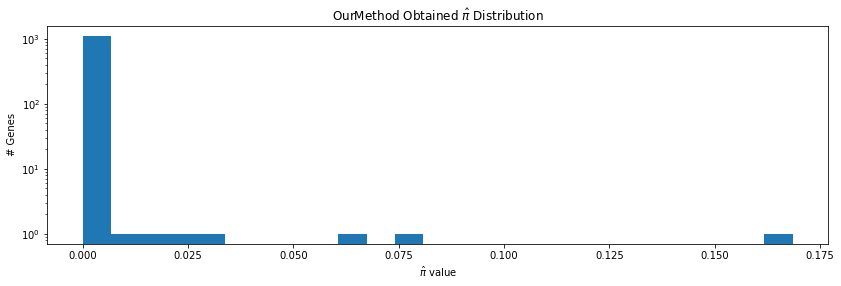

In [6]:
plt.figure(figsize=(14,4))
plt.title('OurMethod Obtained $\hat{\pi}$ Distribution')
plt.xlabel('$\hat{\pi}$ value')
plt.ylabel('# Genes')
plt.hist(ourmethod_df['pi'], log=True, bins=25);


#### BMR PMF Values

For each of IDH1/IDH2, we have the BMR values by sample. Each row in idh1_bmr_df and idh2_bmr_df is a sample and each column indicates the PMF of P(x=k) for k = 0 ... 70.

In [7]:
print('IDH1 BMR PMF Values')
idh1_bmr_df.head()

IDH1 BMR PMF Values


,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
TCGA-AB-2802-03B-01W-0728-08,0.979743,0.020257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-AB-2803-03B-01W-0728-08,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-AB-2804-03B-01W-0728-08,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-AB-2805-03B-01W-0728-08,0.979743,0.020257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-AB-2806-03B-01W-0728-08,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


PMF Values is near 0 for all samples. **Expected Mutation Counts** for each sample are calculated and plotted for IDH1/IDH2:

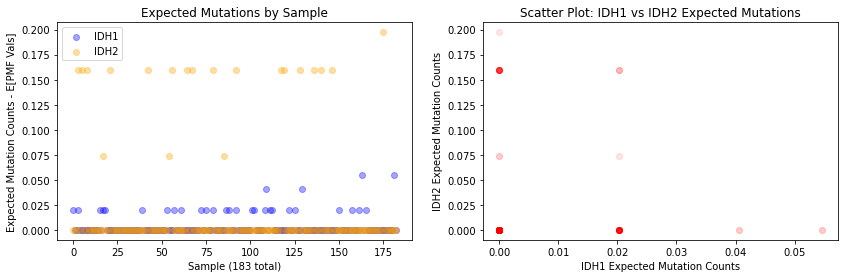

In [10]:
import numpy as np
import matplotlib.pyplot as plt

idh1_exp_vals, idh2_exp_vals = [], []
for idx, row in idh1_bmr_df.iterrows(): idh1_exp_vals.append(np.sum([x * row[x] for x in range(len(row))]))
for idx, row in idh2_bmr_df.iterrows(): idh2_exp_vals.append(np.sum([x * row[x] for x in range(len(row))]))  

# First Plot
x_positions = np.arange(len(idh1_exp_vals))
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.scatter(x_positions, idh1_exp_vals, color='blue', label='IDH1', marker='o', alpha=0.35)
plt.scatter(x_positions, idh2_exp_vals, color='orange', label='IDH2', marker='o', alpha=0.35)
plt.xlabel('Sample (183 total)')
plt.title('Expected Mutations by Sample')
plt.ylabel('Expected Mutation Counts - E[PMF Vals]')
plt.legend()

# Second Plot
plt.subplot(1, 2, 2)
plt.scatter(idh1_exp_vals, idh2_exp_vals, color='red', marker='o', alpha=0.1)
plt.xlabel('IDH1 Expected Mutation Counts')
plt.ylabel('IDH2 Expected Mutation Counts')
plt.title('Scatter Plot: IDH1 vs IDH2 Expected Mutations');

IDH2 has **greater** magnitude of expected mutation counts than IDH1 for its samples w/ nonzero expected mutation counts.

#### Count Matrix

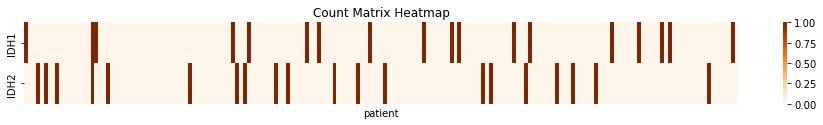

In [11]:
plt.figure(figsize=(16, 1.5))
sns.heatmap(cnt_mat_df[['IDH1', 'IDH2']].T, cmap='Oranges', fmt='d', xticklabels=False)
plt.title('Count Matrix Heatmap')
plt.show()

### Estimating Pi Vals

For each of IDH1/IDH2, do 1D paramter search over all possible values of pi (0-1) and select the value that minimizes the negative log likelihood across all samples.

In [12]:
def calculate_pi_hat(cnts, bmr_probs_dict):
    # Get bmr pmf values for mutation count (c) and (c - 1)
    bmr_probs_c = np.array([bmr_probs_dict[name][c] for name, c in zip(cnts.index, cnts.values)])
    bmr_probs_c_min_1 = np.array([bmr_probs_dict[name][c - 1] if c > 0 else 0 for name, c in zip(cnts.index, cnts.values)])
    # Calculate pi and negative log-likelihood values
    pi_and_nll_vals = []
    for pi in np.linspace(0.01, 0.99, 100):
        likelihoods = (1 - pi) * bmr_probs_c + pi * bmr_probs_c_min_1
        nll = -np.sum(np.log(likelihoods))
        pi_and_nll_vals.append((pi, nll))
    pi_hat = min(pi_and_nll_vals, key=lambda x: x[1])[0] # Find pi value that minimizes negative log-likelihood
    return pi_hat, pi_and_nll_vals

##### IDH1 & IDH2 Side by Side

In [14]:
idh1_pi_hat, idh1_pi_and_nll_vals = calculate_pi_hat(cnt_mat_df['IDH1'], idh1_bmr_dict)
idh2_pi_hat, idh2_pi_and_nll_vals = calculate_pi_hat(cnt_mat_df['IDH2'], idh2_bmr_dict)

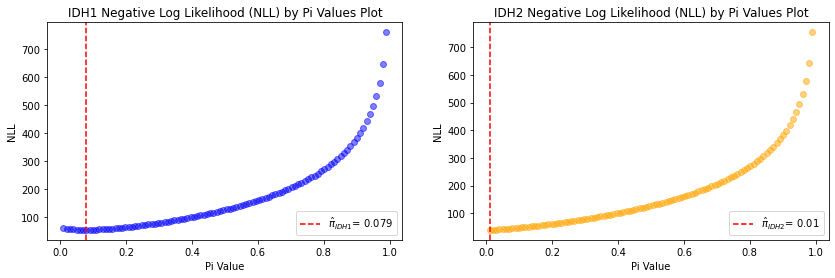

In [16]:
def plot_nll_vs_pi(pi_and_nll_vals, pi_hat, color, label, ax):
    ax.scatter([x[0] for x in pi_and_nll_vals], [x[1] for x in pi_and_nll_vals], color=color, alpha=0.5)
    ax.axvline(pi_hat, color='r', linestyle='--', label=label + f'= {np.round(pi_hat, 3)}')

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
# Plot for IDH1
plot_nll_vs_pi(idh1_pi_and_nll_vals, idh1_pi_hat, 'blue', r'$\hat{\pi}_{IDH1}$', axes[0])
axes[0].set_title('IDH1 Negative Log Likelihood (NLL) by Pi Values Plot')
axes[0].set_xlabel('Pi Value')
axes[0].set_ylabel('NLL')
axes[0].legend()

# Plot for IDH2
plot_nll_vs_pi(idh2_pi_and_nll_vals, idh2_pi_hat, 'orange', r'$\hat{\pi}_{IDH2}$', axes[1])
axes[1].set_title('IDH2 Negative Log Likelihood (NLL) by Pi Values Plot')
axes[1].set_xlabel('Pi Value')
axes[1].set_ylabel('NLL')
axes[1].legend();

#### Additional Plots to Diagnose Root Cause

##### Likelihood Scatter Plots

Using the pi_hat values that minimize the NLL, we scatter plot the likelihoods by sample for IDH1/IDH2

In [17]:
cnts=cnt_mat_df['IDH1']
idh1_bmr_probs_c = np.array([idh1_bmr_dict[name][c] for name, c in zip(cnts.index, cnts.values)])
idh1_bmr_probs_c_min_1 = np.array([idh1_bmr_dict[name][c - 1] if c > 0 else 0 for name, c in zip(cnts.index, cnts.values)])
idh1_likelihoods = (1 - idh1_pi_hat) * idh1_bmr_probs_c + idh1_pi_hat * idh1_bmr_probs_c_min_1

cnts=cnt_mat_df['IDH2']
idh2_bmr_probs_c = np.array([idh2_bmr_dict[name][c] for name, c in zip(cnts.index, cnts.values)])
idh2_bmr_probs_c_min_1 = np.array([idh2_bmr_dict[name][c - 1] if c > 0 else 0 for name, c in zip(cnts.index, cnts.values)])
idh2_likelihoods = (1 - idh2_pi_hat) * idh2_bmr_probs_c + idh2_pi_hat * idh2_bmr_probs_c_min_1

Text(0.5, 1.0, 'Scatter Plot: IDH1 vs IDH2 Likelihoods')

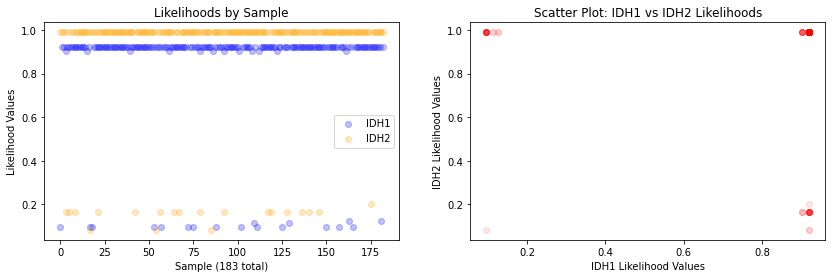

In [18]:
x_positions = np.arange(len(idh1_likelihoods))
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.scatter(x_positions, idh1_likelihoods, color='blue', label='IDH1', marker='o', alpha=0.25)
plt.scatter(x_positions, idh2_likelihoods, color='orange', label='IDH2', marker='o', alpha=0.25)
plt.xlabel('Sample (183 total)')
plt.title('Likelihoods by Sample')
plt.ylabel('Likelihood Values')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(idh1_likelihoods, idh2_likelihoods, color='red', marker='o', alpha=0.1)
plt.xlabel('IDH1 Likelihood Values')
plt.ylabel('IDH2 Likelihood Values')
plt.title('Scatter Plot: IDH1 vs IDH2 Likelihoods')


##### BMR P(x = 0) Scatter Plots

Text(0.5, 1.0, 'BMR P(x = 0) by Sample')

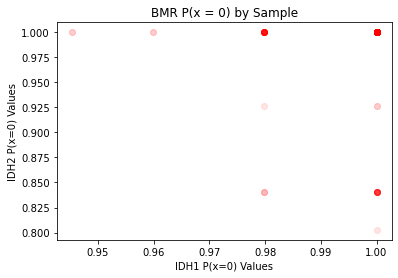

In [19]:
plt.figure(figsize=(6, 4))

idh1_bmr_probs_0 = np.array([idh1_bmr_dict[name][0] for name, c in zip(cnts.index, cnts.values)])
idh2_bmr_probs_0 = np.array([idh2_bmr_dict[name][0] for name, c in zip(cnts.index, cnts.values)])
plt.scatter(idh1_bmr_probs_0, idh2_bmr_probs_0, color='red', marker='o', alpha=0.1)
plt.xlabel('IDH1 P(x=0) Values')
plt.ylabel('IDH2 P(x=0) Values')
plt.title('BMR P(x = 0) by Sample')